# Anomaly Detection in Server Logs using Isolation Forest

This notebook demonstrates how to detect anomalies in web server logs using the Isolation Forest algorithm.

### 1. Import Libraries
We'll start by importing the necessary libraries:
- `pandas` for data manipulation
- `sklearn` for the Isolation Forest model and preprocessing
- `re` for parsing the log file using regular expressions

In [8]:
import pandas as pd
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import numpy as np
import shap
import openai
import os
import matplotlib.pyplot as plt

### 2. Load and Parse Data
The log data is in a semi-structured format. We define a regular expression (regex) to extract specific fields like:
- Timestamp
- Client IP
- Request Path & Method
- Status Code
- Response Size (Bytes)
- Response Time

We iterate through the file `synthetic_logs_10k.csv`, parsing each line and storing the extracted data into a Pandas DataFrame.

In [9]:
# Define the log pattern regex
log_pattern = re.compile(r'<150>(\w{3}\s+\d+\s+\d{2}:\d{2}:\d{2})\s+(\S+)\s+(\S+):\s+(\S+)\s+(\S+)\s+(\d+)\s+(\S+)\s+-\s+-\s+\[(.*?)\]\s+"(.*?)"\s+(\d+)\s+(\S+)\s+(\d+)\s+"(.*?)"\s+"(.*?)"')

data = []
# Read and parse the file
with open('synthetic_logs_10k.csv', 'r') as f:
    for line in f:
        match = log_pattern.match(line.strip())
        if match:
            data.append(match.groups())
        else:
            # Fallback or debug for lines that don't match
            # print(f"Line didn't match: {line.strip()}")
            pass

columns = [
    "syslog_ts", "host", "process", "ip1", "ip2", "session_id", "domain", 
    "apache_ts", "request", "status", "bytes", "response_time", "referer", "user_agent"
]

df = pd.DataFrame(data, columns=columns)
print(f"Loaded {len(df)} records.")
df.head()

Loaded 10000 records.


,syslog_ts,host,process,ip1,ip2,session_id,domain,apache_ts,request,status,bytes,response_time,referer,user_agent
0,Jan 28 08:10:01,servernameabc,httpd[12345],10.0.240.52,0.1.0.1,35786,abc.example.net,28/Jan/2026:08:10:01 +0530,GET /leave/appResources/images/lerf_default.pn...,503,-,4468,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
1,Jan 28 08:10:01,servernameabc,httpd[12345],10.91.94.182,0.1.0.1,81525,abc.example.net,28/Jan/2026:08:10:01 +0530,GET /leave/appResources/css/Custom_font-awesom...,200,7895,10,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,Jan 28 08:10:02,servernameabc,httpd[12345],10.151.91.182,0.1.0.1,70055,abc.example.net,28/Jan/2026:08:10:02 +0530,POST /leaverest/rest/lwpBatch HTTP/1.1,200,2389,42,https://abc.example.com/index.html,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
3,Jan 28 08:10:02,servernameabc,httpd[12345],10.236.14.117,0.1.0.1,22309,abc.example.net,28/Jan/2026:08:10:02 +0530,GET /favicon.ico HTTP/1.1,200,3822,33,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,Jan 28 08:10:03,servernameabc,httpd[12345],10.199.43.68,0.1.0.1,54459,abc.example.net,28/Jan/2026:08:10:03 +0530,GET /leave/appResources/images/lerf_default.pn...,204,-,3405,https://abc.example.com/index.html,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...


### 3. Data Preprocessing
Raw log data needs to be cleaned and formatted before it can be used for machine learning:
- **Bytes**: Convert from string (handling '-') to integer.
- **Response Time & Status**: Convert to integer.
- **HTTP Method**: Extract the method (GET, POST) from the request string and encode it numerically using `LabelEncoder`.

This prepares the `X` dataset for our model.

In [10]:
# Preprocessing
# Fix Bytes: Replace '-' with 0 and convert to integer
df['bytes'] = df['bytes'].replace('-', '0').astype(int)

# Fix Response Time: Ensure it is numeric
df['response_time'] = df['response_time'].astype(int)

# Fix Status: Ensure it is numeric
df['status'] = df['status'].astype(int)

# Extract HTTP Method from the Request string
df['http_method'] = df['request'].apply(lambda x: x.split()[0] if x else "UNKNOWN")

# Encode HTTP Method
method_encoder = LabelEncoder()
df['http_method_encoded'] = method_encoder.fit_transform(df['http_method'])

# Display stats
print(df.describe())
print(df['http_method'].value_counts())

             status         bytes  response_time  http_method_encoded
count  10000.000000  10000.000000   10000.000000         10000.000000
mean     225.622600   8531.566200     434.309100             0.371700
std       77.354714   6388.478717    1098.348674             0.483283
min      200.000000      0.000000       5.000000             0.000000
25%      200.000000   2471.250000      18.000000             0.000000
50%      200.000000   8389.000000      32.000000             0.000000
75%      200.000000  14119.000000      45.000000             1.000000
max      503.000000  19999.000000    5000.000000             1.000000
http_method
GET     6283
POST    3717
Name: count, dtype: int64


### 4. Anomaly Detection
We use **Isolation Forest**, an unsupervised learning algorithm that detects anomalies by isolating observations.
- **Features**: We use `response_time`, `bytes`, `status`, and `http_method_encoded`.
- **Contamination**: Set to `0.05`, assuming about 5% of the data is anomalous.
- **Prediction**: The model assigns a score of `-1` for anomalies and `1` for normal data.

Finally, we filter and display the detected anomalies.

In [11]:
# Define Features for Anomaly Detection
features = ['response_time', 'bytes', 'status', 'http_method_encoded']
X = df[features]

# Train Isolation Forest
# contamination=0.05 assumes ~5% of data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X)

# Predict anomalies
df['anomaly_score'] = iso_forest.predict(X)
# -1 = Anomaly, 1 = Normal

# Filter anomalies
anomalies = df[df['anomaly_score'] == -1]

print(f"Detected {len(anomalies)} anomalies out of {len(df)} records.")
anomalies[['apache_ts', 'request', 'status', 'response_time', 'anomaly_score']].head(10)

Detected 500 anomalies out of 10000 records.


,apache_ts,request,status,response_time,anomaly_score
0,28/Jan/2026:08:10:01 +0530,GET /leave/appResources/images/lerf_default.pn...,503,4468,-1
6,28/Jan/2026:08:10:05 +0530,POST /RightsWeb/myrights/rest/getNewCardBranch...,503,1466,-1
17,28/Jan/2026:08:10:16 +0530,POST /RightsWeb/myrights/rest/getNewCardBranch...,503,2687,-1
44,28/Jan/2026:08:10:38 +0530,GET /favicon.ico HTTP/1.1,204,4592,-1
84,28/Jan/2026:08:11:10 +0530,POST /RightsWeb/myrights/rest/getNewCardBranch...,500,2173,-1
109,28/Jan/2026:08:11:32 +0530,POST /RightsWeb/myrights/rest/getNewCardBranch...,500,855,-1
110,28/Jan/2026:08:11:32 +0530,GET /timesheet/resources/lib/js/json2.js HTTP/1.1,500,591,-1
123,28/Jan/2026:08:11:44 +0530,POST /RightsWeb/myrights/rest/getNewCardBranch...,404,4534,-1
131,28/Jan/2026:08:11:50 +0530,GET /leave/appResources/css/Custom_font-awesom...,204,4533,-1
137,28/Jan/2026:08:11:55 +0530,GET /favicon.ico HTTP/1.1,503,4855,-1


### 5. Analyze New Logs with SHAP and OpenAI
We will now load a new log file (simulating a user upload), detect anomalies using the trained model, and generate explanations using SHAP values and the OpenAI API.

In [ ]:
# Configuration
from keys import OPENAI_API_KEY
UPLOADED_FILE = 'user_log.csv'

# 1. Load and Parse
new_data = []
if os.path.exists(UPLOADED_FILE):
    with open(UPLOADED_FILE, 'r') as f:
        for line in f:
            match = log_pattern.match(line.strip())
            if match:
                new_data.append(match.groups())
    
    new_df = pd.DataFrame(new_data, columns=columns)
    print(f"Loaded {len(new_df)} records from {UPLOADED_FILE}")
else:
    print(f"File {UPLOADED_FILE} not found.")
    new_df = pd.DataFrame(columns=columns)

if not new_df.empty:
    # 2. Preprocess
    new_df['bytes'] = new_df['bytes'].replace('-', '0').astype(int)
    new_df['response_time'] = new_df['response_time'].astype(int)
    new_df['status'] = new_df['status'].astype(int)
    new_df['http_method'] = new_df['request'].apply(lambda x: x.split()[0] if x else "UNKNOWN")
    
    # Encode HTTP Method safely
    known_methods = set(method_encoder.classes_)
    new_df['http_method_encoded'] = new_df['http_method'].apply(
        lambda x: method_encoder.transform([x])[0] if x in known_methods else -1
    )

    # 3. Predict
    X_new = new_df[features]
    new_df['anomaly_score'] = iso_forest.predict(X_new)
    
    new_anomalies = new_df[new_df['anomaly_score'] == -1]
    print(f"Found {len(new_anomalies)} anomalies.")
    
    # 4. SHAP Values
    explainer = shap.TreeExplainer(iso_forest)
    shap_values = explainer.shap_values(X_new)
    
    # Display first few anomalies
    print(new_anomalies[['apache_ts', 'request', 'status', 'response_time', 'anomaly_score']].head())
else:
    print("No data to process.")

Loaded 1000 records from synthetic_logs_1k.csv
Found 49 anomalies.
                     apache_ts  \
0   28/Jan/2026:08:10:00 +0530   
27  28/Jan/2026:08:10:19 +0530   
33  28/Jan/2026:08:10:24 +0530   
86  28/Jan/2026:08:11:04 +0530   
95  28/Jan/2026:08:11:12 +0530   

                                              request  status  response_time  \
0                    POST /api/v1/auth/login HTTP/1.1     503           4366   
27             POST /leaverest/rest/lwpBatch HTTP/1.1     404           2914   
33  POST /RightsWeb/myrights/rest/getNewCardBranch...     500           3422   
86             POST /leaverest/rest/lwpBatch HTTP/1.1     204           4044   
95                   POST /api/v1/auth/login HTTP/1.1     404           4622   

    anomaly_score  
0              -1  
27             -1  
33             -1  
86             -1  
95             -1  



--- Generating Explanations for Anomalies ---

[Log Entry #0]
Request: POST /api/v1/auth/login HTTP/1.1
Status: 503, Time: 4366, Bytes: 0


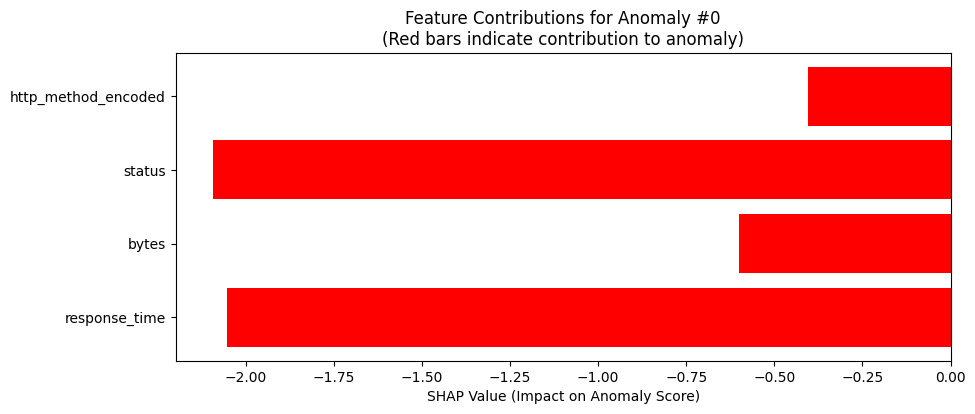

Analysis:
The log entry can be considered anomalous for multiple reasons based on the feature values and the corresponding SHAP (Shapley Additive exPlanations) values. 

1. response_time: The value is considerably high, indicating a significant delay in response time. This delay could be due to various reasons, such as heavy server load, network issues, or inefficient code. The high value (4366ms) and high feature importance (-2.0530 SHAP) suggest this feature's role in the prediction is substantial.

2. bytes: The log shows a response size of 0 bytes. This is abnormal because if a request is successful or even if it results in an error, the server will normally return some data in the response.

[Log Entry #27]
Request: POST /leaverest/rest/lwpBatch HTTP/1.1
Status: 404, Time: 2914, Bytes: 0


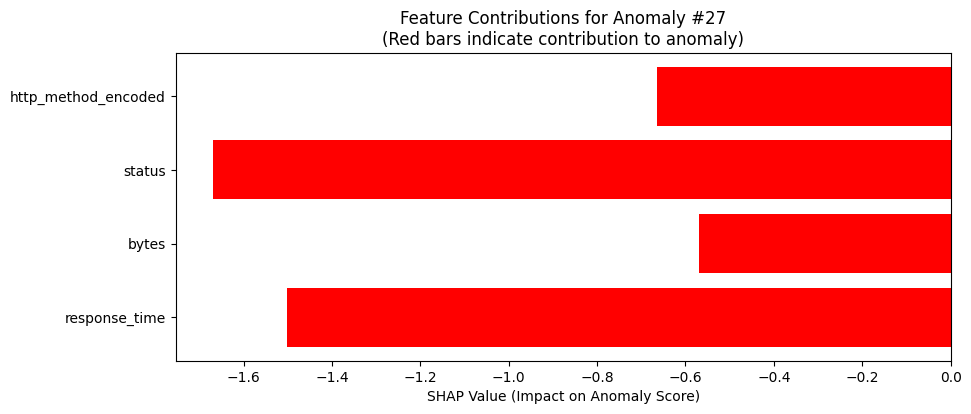

Analysis:
The anomaly score for this log entry has likely been influenced by a few factors.

Firstly, the response time is quite high at 2914 milliseconds. This is signaled by a negative SHAP value which indicates that this response time is increasing the anomaly score. Typically, server response times are expected to be much lower, and such a high response time could be indicative of a performance issue such as server load problems or issues with the application being accessed.

Secondly, there are zero bytes in the response, which is unusual. A response of zero bytes might mean that the request was unsuccessful or faced an error in processing, which merits further investigation.

The HTTP status code returned is 404, which means the requested resource was not found on the server.

[Log Entry #33]
Request: POST /RightsWeb/myrights/rest/getNewCardBranch HTTP/1.1
Status: 500, Time: 3422, Bytes: 0


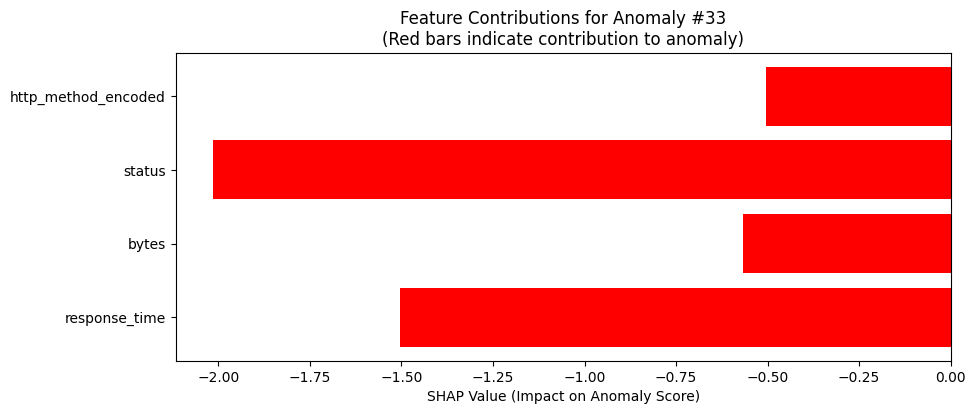

Analysis:
The anomalous nature of this log entry can be analyzed based on the provided SHAP values for each feature. 

1. Response Time: The time taken to serve the request was 3422 milliseconds, which is quite high. Most response times are usually within a few hundred milliseconds. This could be indicative of a performance issue in the server.

2. Bytes: This value, set at 0, is suspicious. It suggests no data was sent in response to the request. This is unusual as normally at least some data, such as HTTP headers, would be sent even if there is an error.

3. Status: The HTTP status code is 500, which indicates a server error, and it's definitely not a common status code. This


In [15]:
def get_openai_explanation(row, shap_vals, feature_names, api_key):
    if not api_key or api_key == "YOUR_OPENAI_API_KEY":
        return "OpenAI API Key not provided. Please set the OPENAI_API_KEY variable."

    client = openai.OpenAI(api_key=api_key)
    
    # Create a summary of feature contributions
    contributions = []
    for feature, value, shap_val in zip(feature_names, row, shap_vals):
        contributions.append(f"{feature}: {value} (SHAP: {shap_val:.4f})")
    
    contribution_str = "\n".join(contributions)
    
    prompt = f"""
    You are a cybersecurity expert analyzing server logs.
    An anomaly detection model (Isolation Forest) flagged the following log entry as anomalous.
    
    Feature Analysis (SHAP values):
    {contribution_str}
    
    Context:
    - Status: HTTP status code.
    - Bytes: Size of the response.
    - Response Time: Time taken to serve the request (ms).
    - HTTP Method Encoded: Numeric representation of GET, POST, etc.
    
    Explain why this log entry is anomalous based on these values. Is it a potential security threat or a performance issue?
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4", # or gpt-3.5-turbo
            messages=[
                {"role": "system", "content": "You are a helpful cybersecurity assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=150
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error communicating with OpenAI: {e}"

def plot_anomaly_explanation(shap_vals, feature_names, index):
    plt.figure(figsize=(10, 4))
    # In Isolation Forest, lower score means more anomalous.
    # Negative SHAP values push the score down (towards anomaly).
    colors = ['red' if x < 0 else 'blue' for x in shap_vals]
    
    y_pos = np.arange(len(feature_names))
    plt.barh(y_pos, shap_vals, color=colors, align='center')
    plt.yticks(y_pos, feature_names)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    plt.xlabel('SHAP Value (Impact on Anomaly Score)')
    plt.title(f'Feature Contributions for Anomaly #{index}\n(Red bars indicate contribution to anomaly)')
    plt.show()

# Explain first 3 anomalies
if not new_anomalies.empty and 'shap_values' in locals():
    print("\n--- Generating Explanations for Anomalies ---")
    anomaly_indices = new_df.index[new_df['anomaly_score'] == -1].tolist()
    
    for idx in anomaly_indices[:3]: # Limit to 3 for demo
        row_values = X_new.loc[idx]
        shap_row = shap_values[idx]
        
        print(f"\n[Log Entry #{idx}]")
        print(f"Request: {new_df.loc[idx, 'request']}")
        print(f"Status: {new_df.loc[idx, 'status']}, Time: {new_df.loc[idx, 'response_time']}, Bytes: {new_df.loc[idx, 'bytes']}")
        
        # Plot graph
        plot_anomaly_explanation(shap_row, features, idx)

        # Get Text Explanation
        explanation = get_openai_explanation(row_values, shap_row, features, OPENAI_API_KEY)
        print(f"Analysis:\n{explanation}")
else:
    print("No anomalies to explain.")